# Detecting misinformation on Twitter

_Fundamentals of Machine Learning - Master Data Driven Design_

_Freek Plak (1792713)_

Following a group of HBO-ict students from the University of Applied Sciences Utrecht that took part in the ICMCIS 2020 challenge. We (Ali Afshar, Sasha Bunink, Yuan Hu, Nayereh Parpanchi, Shania Spierings and me) a group of Data Driven Design students also from the University of Applied Sciences Utrecht tried to follow up their success in detecting misinformation in Tweets.

The research question we have: How well can we predict if a Tweet contains misinformation using machine learning?

We worked together on building features, but each used a different model to get the most accurate prediction. The earlier work of the HBO-ict students was used as inspiration in coming up with these features, they found that capital casing and word frequency are the best features to predict misinformation. While they also tested: tweet length, punctuation usage and emoji usage (Bediar et al., 2020)

We are given a dataset that comes from the [ICMCIS 2020 Challenge](https://www.kaggle.com/c/icmcis2020/data), Next to the tweet text, the dataset contains 2 fields (ICMCIS 2020 Challenge, 2020):

- **tweet_id**: the integer representation of the unique identifier for a Tweet
- **label**: the target that is to be predicted, indicating that the Tweet is linked to misinformation (label=0) or trusted information (label=1)

In this document I'll walk you through my steps in detecting misinformation on Twitter

## Import needed packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import json

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split #We need this to split the dataset in a train and test set
from sklearn.metrics import confusion_matrix #We use this for creating a confusion matrix as input for recall and preciscion calculations
from sklearn.ensemble import RandomForestClassifier #The model we use for classification

## First look at the dataset

Before we get started a first look at the dataset:

In [2]:
df = pd.read_csv('tweets_labeled.csv')
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in dataset')
df.head()

There are 225405 rows and 3 columns in dataset


,tweet_id,text,label
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0


We can see that there are 225,405 records and the 3 columns as explained in the introduction. The tweet_id seems unvaluable to us as it's an unique identifier for each tweet. The label is what we want to predict, so with feature building we focused on the tweet text.

## Import features from peers
In this document the following features are imported:
- Vader sentiment (Sasha Bunink)
- TextBlob sentiment (Sasha Bunink)
- Character count (Sasha Bunink)
- Count hashtags (Sasha Bunink)
- Count mentions (Sasha Bunink)
- Reading ease (Nayereh Parpanchi)
- Part-of-speech tagging (Shania Spierings)
- Reference count (Shania Spierings)

In [3]:
import functions_others as f

## Define other features

Next to the imported features, we are also using some features I have written myself:
- Sentiment from the AFINN-111 and SentStrength libraries
- Sentiment from the ANEW library
- Extreme sentiment (to flag an extreme value)
- Check if numbers are in a tweet
- Check how many numbers are in a tweet
- Check and flag if they use "percentage" as a word or "%" as a sign in a tweet
- Word count
- Flag if a tweet contains a link
- Average word length
- Longest word length

Also defined some general functions to make functions work and to label if a tweet is a Retweet. This last bit we need to clean the datafile later.

In [4]:
""" 
############## General functions ##############
"""

def open_file(filename):
    with open(filename) as json_file:
        return json.load(json_file)

def RT(tweet):
    if ('RT @' in tweet):
        return 1
    else:
        return 0

def clean_words(word):
    word = word.lower()
    word = word.replace(",", "")
    word = word.replace(".", "")
    word = word.replace(":", "")
    word = word.replace("?", "")
    word = word.replace("#", "")
    word = word.replace("(", "")
    word = word.replace(")", "")
    word = word.replace("!", "")
    word = word.replace("'", "")
    word = word.replace(";", "")
    word = word.replace("&", "")
    word = word.replace("'", "")
    return word

### Sentiment features

While researching possible solutions we came across a lot of researches that use sentiment analysis in detecting misinformation, it is mostly used as add on but can yield a higher accuracy in the detection of fake news (Bhutani et al., 2019, pp. 1–3). In this specific study they combine both Naive Bayes and Random Forrest models with sentiment as a big variable. 

As a lot of sentiment libraries for English have a limited amount of words we combined a couple of the most important libraries (Al-Shabi, 2020).

We have 5 different sentiment libraries:

__2 from packages__
- TextBlob
- VaderSentiment

__3 word sentiment libraries__
- AFINN-111
- SentiStrength
- ANEW

Before I started with this function we created dictionaries (in a json file) from the word sentiment libraries. As AFINN and SentStrength both scored words on a -2 to +2 scale I could combine those. If a word was scored in both libraries I chose AFINN's over SentiStrength's score based on the performance in a research by Al-Shabi (Al-Shabi, 2020).

ANEW scored sentiment on 3 levels: Valence, Dominance and Arousal:
- Valence how positive or negative a word is (scores between 1.25 - 8.82, where the lowest score is the most negative)
- Dominance how important the word is to the sentence
- Arousal how much impact a word has on the person reading it

To get to positive/negative sentiment I transformed the valence to a -2 till +2 scale value. Then multiplied valence with the sum of dominance and arousal (the effect of the word for the sentence) $Valence * (Arousal + Dominance)$.

The functions clean the words in a tweet, make it lowercase and check it for value on the dictionary. The sum of all values of found words in a tweet make the tweet's sentiment score.

After the sentiment we can also look for extreme sentiment, we do this based on extreme values within the df.


__Personal assumptions:__

Assumptions are that tweets with an extreme and/or negative sentiment are more likely to be misinformation, as when you have extreme emotions or are negative towards a topic you are more likely to justify your opinion with unsuported arguments.

In [5]:
""" 
############## Sentiment features ##############
"""

def add_sentiment(tweet):
    #open the dictionary with the sentiment and set default sentiment to 0 (neutral)
    words = open_file('sentiment_dict.json')
    sentiment = 0
    
    #for each word in the tweet
    for w in tweet.split():
        #clean the word, remove hashtags, punctuation, etc. and make it lower case
        w = clean_words(w)
        w = w.lower()
    
        #loop through dictionary and see if we can find a match
        for word in words:
            if word == w:
                #if we have a match add this sentiment to the total amount
                sentiment += words[w]
            else: pass

    #after all words are matched return total sum of sentiment
    return sentiment

def add_anew_sentiment(tweet):
    #open the dictionary with the sentiment and set default sentiment to 0 (neutral)
    words = open_file('anew_sentiment_dict.json')
    sentiment = 0
    
    #for each word in the tweet
    for w in tweet.split():
        #clean the word, remove hashtags, punctuation, etc. and make it lower case
        w = clean_words(w)
        w = w.lower()
    
        #loop through dictionary and see if we can find a match
        for word in words:
            if word == w:
                #if we have a match add this sentiment to the total amount
                sentiment += words[w]
            else: pass

    #after all words are matched return total sum of sentiment
    return sentiment

def add_extreme_sentiment(df):
    df['extreme_AFINN_SentStrength'] = np.where((df['sentiment_AFINN_SentStrength'] > 3) | (df['sentiment_AFINN_SentStrength'] < -3), 1, 0)
    df['extreme_textblob'] = np.where((df['sentiment_textblob'] > 0.25) | (df['sentiment_textblob'] < -0.25), 1, 0)
    df['extreme_ANEW'] = np.where((df['sentiment_ANEW'] > 20) | (df['sentiment_ANEW'] < -19), 1, 0)
    df['extreme_Vader'] = np.where((df['compound'] > 0.5) | (df['compound'] < -0.3), 1, 0)
    df['extreme_combined'] = df['extreme_AFINN_SentStrength'] + df['extreme_textblob'] + df['extreme_ANEW'] + df['extreme_Vader']
    return df

### Number features

I couldn't find any research specific to the relation of the usage of numbers / mentioning of numbers in misinformation. I do feel there could be a relation and therefor have written some features.

This part contains features to:
- check if a tweet contains a digit (1/0)
- find the amount of numerical characters in a tweet (int)
- returns if a tweet contains a '%' sign or the word 'percentage' (1/0)


__Personal assumption:__

My assumption is that if a tweet comes with numbers and/or with a specific percentage value it's easier fact checked and less harder to make up. So chances are that a tweet is more trustworthy. 

In [6]:
""" 
############## Number features ##############
"""

def check_for_numbers(tweet):
    #set default to 0
    contains_digit = 0

    #loop through words
    for w in tweet.split():
        #if the word is a mention or a link we don't count them
        if '@' in w or 'http' in w:
            pass
        else:
            #loop through characters
            for character in w:
                if character.isdigit():
                    #there is a digit
                    contains_digit = 1
                else: 
                    pass
    
    return contains_digit

def amount_of_numbers(tweet):
    #set default to 0
    digits = 0

    #loop through words
    for w in tweet.split():
        #if the word is a mention or a link we don't count them
        if '@' in w or 'http' in w:
            pass
        else:
            #loop through characters
            for character in w:
                if character.isdigit():
                    #there is a digit
                    digits += 1
                else: 
                    pass
    
    return digits

def percentage_use(tweet):
    #if percentage sign or word is in tweet than it's true (1) other is false (0)
    if '%' in tweet:
        return 1
    elif 'percentage' in tweet:
        return 1
    else:
        return 0

### Word features

When researching fake news there are a lot of researches to specific word usage, a good example is the recent research (Li et al., 2019) that shows very promising result in combination with neural networks. As other students in my group worked on features that go in to specific word usage and I expected that word complexity might be of relevance as well. I couldn't find much research on that specific topic, there is one research (Su et al., 2020) that amongs other features looked into word complexity and get a good accuracy. How the specific complexity features perform isn't completely clear, but that it is of importance is clear.

This document contains features to:
- count the amount of words in a tweet (excluding mentions and websites) (int)
- if a tweet contains a link (1/0)
- How much characters the average word contains, excluding mentions and websites (int)
- How big the word with most characters is, excluding mentions and websites (int)


__Personal assumption:__

My assumption is that having less but longer words are posted by people being more likely to be higher educated and therefore have a better background in fact-checking and think longer about the specific things they say. So it's more likely to be trustworthy tweets. Another assumption is that tweets containing a link are supported by a different source confirming the information which is also more likely to be trustworthy (allthough the questions remains how trustworthy the source is, so we expect a low correlation)

In [7]:
""" 
############## Word features ##############
"""

def word_count(tweet):
    #set defaults to 0
    word_count = 0
    #for each word in the tweet that is received as input
    for w in tweet.split():
        #if the word is a mention or a link we don't count them
        if '@' in w or 'http' in w:
            pass
        else:
            #add 1 to the count of the amount of words
            word_count +=1

    #return the word count        
    return word_count

def contains_link(tweet):
    #if a tweet contains a link (has 'http' in it) return 1 (true) otherwise return 0 (false)
    if 'http' in tweet:
        return 1
    else:
        return 0

def average_word_length(tweet):
    #set defaults to 0
    word_count = 0
    word_length = 0

    #for each word in the tweet that is received as input
    for w in tweet.split():
        #if the word is a mention or a link we don't count them
        if '@' in w or 'http' in w:
            pass
        else:
            #clean the word, remove hashtags, punctuation, etc.
            w = clean_words(w)
            #add the length of this word to the total
            word_length = word_length + len(w)
            #add 1 to the count of the amount of words
            word_count +=1
    #calculate average by dividing word length with the amount of words
    if word_count != 0 and word_length != 0:
        average_word_length = word_length/word_count
    else:
        average_word_length = 0
    #returning the average
    return average_word_length

def longest_word(tweet):
    #set default to 0
    longest_word = 0

    #for each word in the tweet that is received as input
    for w in tweet.split():
        #if the word is a mention or a link we don't count them
        if '@' in w or 'http' in w:
            pass
        else:
            #clean the word, remove hashtags, punctuation, etc.
            w = clean_words(w)
            #calculate the length of the word (amount of characters)
            word_length = len(w)

            #if this word is the longest word replace the length of the longest word
            if word_length > longest_word:
                longest_word = word_length
            else:
                pass
    #after for loop return result of the longest word
    return longest_word

## Import Dataset #2

Imported a dataset with sentiment, readability, part-of-speech tagging and reference count features included. The running of the features is possible and also in this document, but running takes 20 min to multiple days per feature depending on the feature and the processing power of the computer. 

In [8]:
df = pd.read_csv('df_labeled_including_some_features.csv', index_col=0)
df.head()

,tweet_id,text,label,compound,neg,neu,pos,extreme_Vader,sentiment_textblob,extreme_textblob,...,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1,0.4215,0.0,0.882,0.118,0,0.00,0,...,2,0,1,4,11,0,0,1,4,0
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1,0.6369,0.0,0.766,0.234,1,0.25,0,...,1,3,0,1,9,0,0,1,2,0
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0,0.0000,0.0,1.000,0.000,0,0.00,0,...,0,0,0,0,5,0,0,1,0,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0,0.0000,0.0,1.000,0.000,0,0.00,0,...,2,1,0,2,9,0,2,1,2,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0,0.2732,0.0,0.900,0.100,0,0.00,0,...,3,0,0,0,13,2,0,2,1,0


## Data Cleaning

To make some features work better, to strip the tweets of mentions, links and the 'RT' add-on. As some other features still need this, I also kept the original text. I use a feature of Shania Spiering to clean the text.

We also drop the 'tweet_id' column as this is just an identifier of the tweet text and we don't have any need for the field.

In [9]:
df['clean_text'] = df['text'].apply(f.wash_pandas_str)
df = df.drop('tweet_id', 1) #Drop the column as we don't have any need for this field.

## Applying features of peers to Data

First function's I also added in the imported DataFrame because of loading time's

In [ ]:
"""
################## Sasha Bunink ##################
"""
df = f.add_vader_sentiment(df) #Returns multiple columns compound, neg, neu, pos with the sentiment score for Vader. compound = sum of neg(negative), neu(neutral) and pos(positive) sentiment scores
df = f.textblob(df) #Returns a single sentiment value between -1 and + 1

"""
################## Nayereh Parpanchi ##################
"""
df = f.reading_ease(df) #Provides a readability score to the tweet

"""
################## Shania Spierings ##################
"""
df = f.pos_numbers(df) #Provides multiple columns with the amount of part-of-speech categories per tweet (., ADP, ADV, CONJ, DET, NOUN, PRON, PRT, VERB, X)
df = f.add_ref_count(df) #Checks if there are reference words (from the reference word json list) in a tweet and returns the amount of reference words.

And some features that can be run within a short amount of time.

In [10]:
"""
################## Ali Afshar ##################
"""
df['capital_count'] = df['clean_text'].apply(f.count_capital_letters) #Counts the amount of capitals in a Tweet, this was a significant feature according to the IT students before us.

"""
################## Sasha Bunink ##################
"""
df = f.show_char_count(df) #Counts the characters in the Tweet
df = f.stopwords_count(df) #Counts the stopwords in the Tweet
df = f.count_hashtags(df) #Counts the hashtags in the Tweet
df = f.count_mentions(df) #Counts the mentions in the Tweet

## Applying sentiment features to Data

These also take quite some time, so it's better to use the imported DataFrame where they are already included.

In [ ]:
""" 
############## Sentiment features ##############
"""
df['sentiment_AFINN_SentStrength'] = df['clean_text'].apply(add_sentiment)#Returns column sentiment_AFINN_SentStrength with the sentiment score for the combination of the AFINN and SentStrength libraries
df['sentiment_ANEW'] = df['clean_text'].apply(add_anew_sentiment)#Returns column sentiment_ANEW with the sentiment score for ANEW library

""" 
############## Extreme sentiment features ##############
"""
df = add_extreme_sentiment(df) #adds 5 columns: 1 for all 4 sentiment scores that give a '1' if the sentiment score is among the extreme values or '0' if it isn't extreme. And a column that sums these 4 up to give a combination of the 4.

## Applying other features to Data

These features are explained more in detail higher in this file where we defined them.

In [11]:
""" 
############## Word features ##############
"""
df['average_word_length'] = df['text'].apply(average_word_length) #returns an int with the average word length
df['longest_word'] = df['text'].apply(longest_word) #returns an int with the amount of characters in the longest word
df['word_count'] = df['text'].apply(word_count) #returns an int with the total amount of words in a tweet text
df['contains_link'] = df['text'].apply(contains_link) #returns a '1' if a tweet contains a link or '0' if it doesn't
""" 
############## Number features ##############
"""
df['check_for_numbers'] = df['text'].apply(check_for_numbers) #returns a '1' if a tweet contains a digit, or '0' if it doesn't
df['amount_of_numbers'] = df['text'].apply(amount_of_numbers) #returns an int with the amount of numbers in a tweet
df['percentage_use'] = df['text'].apply(percentage_use) #returns a '1' if a tweet contains a '%' sign or the word 'percentage' and '0' if it doesn't

## No Retweets

Having retweets in the dataset, provides 2 problems:
- there is a big chance the same tweet ends up in both the training as the test set. Which contaminates the test set.
- If there are multiple tweets with the same text in the training set, some features that work specifically on these tweets are given a bigger importance over other tweets. Harming the prediction capability on other tweets.

Therefor I choose to create 2 DataFrames:
- One to compare with other students and earlier research including retweets
- One to give a better result in how this model will perform on a real set

Here we add RT's as a column so we can then seperate them in two DataFrames.

In [12]:
df['RT'] = df['text'].apply(RT) #Apply RT function returns True/False per Tweet

## DataFrame's to work with

Here we define two DataFrame's one with no Retweets to measure more accurately how the model performs and one with Retweets to compare to other students.

In [13]:
#No retweet DataFrame
df_noRT = df[df.RT == 0] #Select only the cases where RT is False 
df_noRT = df_noRT.drop('RT', 1) #Drop the column as we don't need it anymore
df = df.drop('RT', 1) #Drop the column as we don't need it anymore
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in dataset')
df.head()

There are 225365 rows and 41 columns in dataset


,text,label,compound,neg,neu,pos,extreme_Vader,sentiment_textblob,extreme_textblob,sentiment_AFINN_SentStrength,...,stopwords,hashtags,mentions,average_word_length,longest_word,word_count,contains_link,check_for_numbers,amount_of_numbers,percentage_use
0,'RT @SenJeffMerkley: The Endangered Species Ac...,1,0.4215,0.0,0.882,0.118,0,0.00,0,2,...,7,0,1,4.545455,10,22,0,0,0,0
1,'RT @LindseyGrahamSC: Interesting concept -- i...,1,0.6369,0.0,0.766,0.234,1,0.25,0,4,...,1,0,1,5.105263,11,19,0,0,0,0
2,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0,0.0000,0.0,1.000,0.000,0,0.00,0,0,...,0,2,1,9.000000,13,3,1,0,0,0
3,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0,0.0000,0.0,1.000,0.000,0,0.00,0,0,...,4,0,1,4.000000,7,14,1,0,0,0
4,'RT @TheOnion: Sweden Announces Plan To Get 10...,0,0.2732,0.0,0.900,0.100,0,0.00,0,-2,...,0,0,1,4.470588,9,17,1,1,7,1


### Value counts label

To get a rough estimation on the total records we are working with and the proportions of which amount of Tweets are trustworthy against Tweets that are linked to misinformation. We make value counts of the label and draw a bar chart. We do this for both de dataset without retweets as the one with.

__Without Retweets__

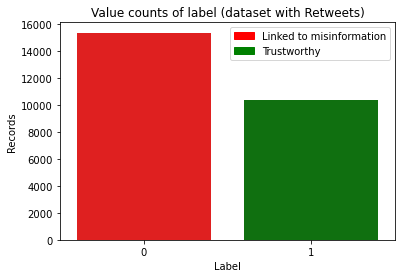

Data without Retweets:
0    15381
1    10357
Name: label, dtype: int64


In [14]:
x = df_noRT.label.value_counts() #calculating the values and putting them in x
sns.barplot(x.index, x, palette=["red", "green"]) #making a bar plot with red and green bar

plt.title('Value counts of label (dataset with Retweets)') #set plot title
plt.ylabel('Records') #set plot y-axes
plt.xlabel('Label') #set plot x-axes

red_patch = mpatches.Patch(color='red', label='Linked to misinformation') #define legend for red bar
green_patch = mpatches.Patch(color='green', label='Trustworthy') #define legend for green bar
plt.legend(handles=[red_patch, green_patch]) #show legend
plt.show() #show plot

print(f"Data without Retweets:\n{x}") #display actual values

We can see that we have a total of 25,738 records. From that total amount roughly 60% of the records are linked to misinformation ($(\frac{15,381}{15,381+10,357})*100 = 59.76$).

__With Retweets__

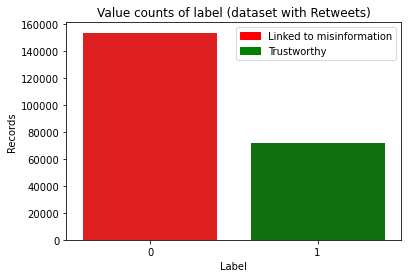

Data with Retweets:
0    153453
1     71912
Name: label, dtype: int64


In [15]:
x = df.label.value_counts() #calculating the values and putting them in x
sns.barplot(x.index, x, palette=["red", "green"]) #making a bar plot with red and green bar

plt.title('Value counts of label (dataset with Retweets)') #set plot title
plt.ylabel('Records') #set plot y-axes
plt.xlabel('Label') #set plot x-axes

red_patch = mpatches.Patch(color='red', label='Linked to misinformation') #define legend for red bar
green_patch = mpatches.Patch(color='green', label='Trustworthy') #define legend for green bar
plt.legend(handles=[red_patch, green_patch]) #show legend
plt.show() #show plot

print(f"Data with Retweets:\n{x}") #display actual values

We can see the total set including retweets contains 225,365 records (almost a ten fold) but here roughly 68% of the records are linked to misinformation ($(\frac{153,453}{153,453+71,912})*100 = 68.09$)

## Correlations

We first put the correlations in a table, and later also in a heatmap for better visualisation.

As we want to predict the label we look for correlations with the label. Usually you also want to discard features that have a high correlation between eachother. But as we have quite a large dataset and use random forest which has a decorrelating factor, we probably don't have to worry about that. 

$r$ value's (correlation coefficient) are always between +1 and -1. A value of 0 means there is no correlation at all, 1 or -1 is a perfect (positive or negative) correlation. 
- below -0.7 or above 0.7 is a strong correlation
- below -0.5 or above 0.5 is a moderate correlation
- below -0.3 or above 0.3 is a weak correlation

In [16]:
corr = df.corr()
corr

,label,compound,neg,neu,pos,extreme_Vader,sentiment_textblob,extreme_textblob,sentiment_AFINN_SentStrength,extreme_AFINN_SentStrength,...,stopwords,hashtags,mentions,average_word_length,longest_word,word_count,contains_link,check_for_numbers,amount_of_numbers,percentage_use
label,1.000000,0.032837,-0.081514,0.089952,-0.029315,-0.048321,0.016798,-0.082844,0.035693,-0.051987,...,0.521412,-0.055979,-0.022321,-0.025209,0.176621,0.446800,-0.681918,0.004209,0.012536,0.037584
compound,0.032837,1.000000,-0.758167,0.159447,0.691185,-0.416737,0.483020,-0.016781,0.751822,-0.239236,...,-0.028022,-0.005263,-0.025748,-0.024035,0.010534,0.011806,-0.048309,0.055032,0.045009,0.066309
neg,-0.081514,-0.758167,1.000000,-0.722641,-0.183080,0.644590,-0.396488,0.222859,-0.682978,0.431839,...,0.023305,-0.070745,-0.011348,0.003789,-0.009333,0.078470,0.046383,-0.028805,-0.022245,-0.069002
neu,0.089952,0.159447,-0.722641,1.000000,-0.547238,-0.602918,0.085662,-0.320919,0.279394,-0.409215,...,-0.028247,0.127285,0.050334,0.032558,0.009007,-0.152448,-0.022013,0.013419,0.001919,0.039166
pos,-0.029315,0.691185,-0.183080,-0.547238,1.000000,0.076985,0.358352,0.186688,0.429582,0.059170,...,0.011928,-0.095410,-0.057843,-0.050875,-0.001490,0.121731,-0.024756,0.015491,0.024026,0.027856
extreme_Vader,-0.048321,-0.416737,0.644590,-0.602918,0.076985,1.000000,-0.202495,0.215912,-0.330889,0.445769,...,0.077978,-0.075169,0.000983,0.008156,0.078269,0.226377,-0.038153,-0.046064,-0.061125,-0.043777
sentiment_textblob,0.016798,0.483020,-0.396488,0.085662,0.358352,-0.202495,1.000000,0.065674,0.454893,-0.110832,...,0.000267,-0.012042,-0.024106,-0.007634,0.039893,0.059695,-0.015455,-0.005823,0.009463,0.019336
extreme_textblob,-0.082844,-0.016781,0.222859,-0.320919,0.186688,0.215912,0.065674,1.000000,-0.062967,0.238026,...,0.053736,-0.029307,0.001515,0.016234,0.030755,0.086964,0.017528,-0.068742,-0.037995,-0.050344
sentiment_AFINN_SentStrength,0.035693,0.751822,-0.682978,0.279394,0.429582,-0.330889,0.454893,-0.062967,1.000000,-0.375628,...,-0.056648,0.031705,-0.035072,-0.022624,0.015609,-0.042842,-0.016566,0.022121,0.020150,0.055414
extreme_AFINN_SentStrength,-0.051987,-0.239236,0.431839,-0.409215,0.059170,0.445769,-0.110832,0.238026,-0.375628,1.000000,...,0.012268,-0.061614,0.015088,-0.000322,0.025531,0.140578,0.003088,-0.042699,-0.030895,0.015440


Correlation visualized in a heatmap:

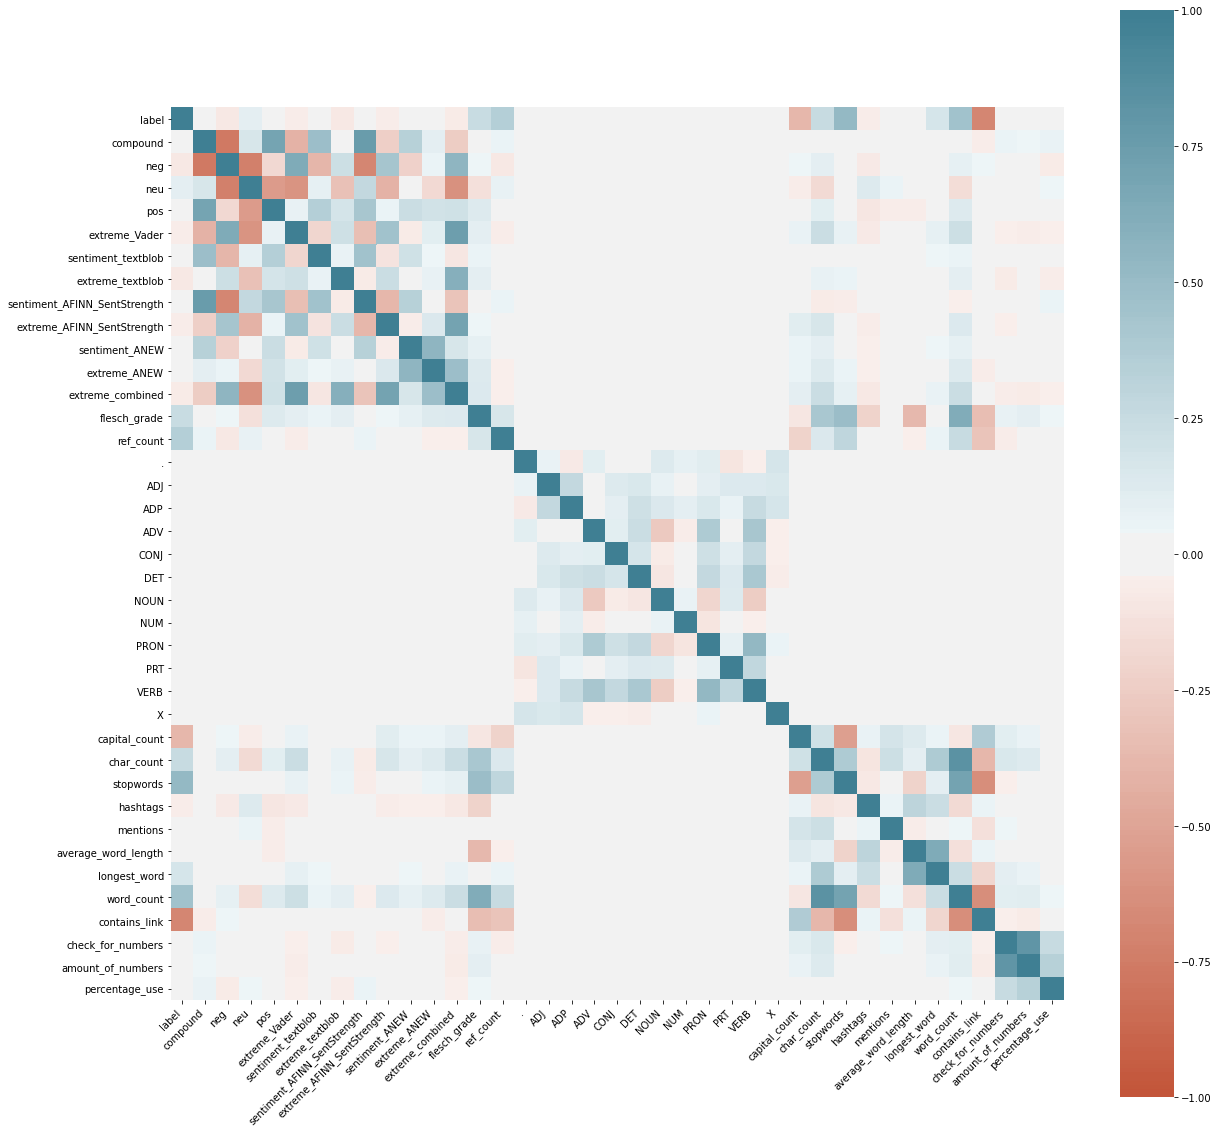

In [17]:
plt.figure(figsize=(20,20)) #Make it bigger
# sns.heatmap(corr)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


__Also for the one without RT's__



In [18]:
corr = df_noRT.corr()
corr

,label,compound,neg,neu,pos,extreme_Vader,sentiment_textblob,extreme_textblob,sentiment_AFINN_SentStrength,extreme_AFINN_SentStrength,...,stopwords,hashtags,mentions,average_word_length,longest_word,word_count,contains_link,check_for_numbers,amount_of_numbers,percentage_use
label,1.000000,-0.010295,0.016418,-0.012252,-0.001487,0.070044,0.038871,-0.037173,-0.048797,0.018772,...,0.144978,-0.001690,-0.140412,0.142744,0.318994,0.366830,0.016178,0.028073,0.021899,0.000044
compound,-0.010295,1.000000,-0.746286,0.148949,0.624931,-0.429539,0.394414,-0.019170,0.758647,-0.303536,...,-0.047454,0.020347,-0.017234,-0.023693,-0.025084,-0.083855,0.023052,0.003859,0.013974,0.025235
neg,0.016418,-0.746286,1.000000,-0.692390,-0.163580,0.637851,-0.300685,0.205316,-0.605264,0.406571,...,0.059235,-0.042134,-0.047004,0.041097,0.063804,0.119174,-0.014150,-0.032465,-0.025325,-0.023251
neu,-0.012252,0.148949,-0.692390,1.000000,-0.598543,-0.607163,-0.016236,-0.335193,0.168501,-0.368347,...,-0.061424,0.052990,0.094884,-0.039375,-0.072255,-0.122978,0.003342,0.049227,0.031372,0.016949
pos,-0.001487,0.624931,-0.163580,-0.598543,1.000000,0.121964,0.356033,0.230342,0.441623,0.052258,...,0.018225,-0.025675,-0.077541,0.008200,0.027952,0.035823,0.011140,-0.031253,-0.014769,0.002623
extreme_Vader,0.070044,-0.429539,0.637851,-0.607163,0.121964,1.000000,-0.092311,0.267647,-0.357118,0.435119,...,0.178203,-0.038105,-0.033955,0.039173,0.115928,0.267767,-0.026815,0.005200,-0.011763,-0.020691
sentiment_textblob,0.038871,0.394414,-0.300685,-0.016236,0.356033,-0.092311,1.000000,0.098492,0.388296,-0.091172,...,0.034208,0.013075,-0.025333,-0.015466,0.010050,0.027937,-0.034515,-0.005395,0.004551,0.007584
extreme_textblob,-0.037173,-0.019170,0.205316,-0.335193,0.230342,0.267647,0.098492,1.000000,-0.025563,0.203824,...,0.136419,-0.015188,-0.040030,-0.005019,0.022798,0.129818,-0.037783,0.006391,0.024887,0.005137
sentiment_AFINN_SentStrength,-0.048797,0.758647,-0.605264,0.168501,0.441623,-0.357118,0.388296,-0.025563,1.000000,-0.454839,...,-0.050367,0.019365,-0.024316,-0.038650,-0.059772,-0.157092,0.024765,-0.028923,-0.014857,0.007882
extreme_AFINN_SentStrength,0.018772,-0.303536,0.406571,-0.368347,0.052258,0.435119,-0.091172,0.203824,-0.454839,1.000000,...,0.150379,-0.017838,-0.001498,0.006750,0.062224,0.231820,-0.047480,0.003277,-0.009005,-0.012887


These graphs and table's show that there are just a few features with an interesting correlation with the label. The heatmap also shows there are some big correlations between certain features.

## Subset based on correlation

Some of the features with the highest correlation (on the original dataset):

__moderate relation__
- contains_link (-0.681918)
- stopwords (0.521412)

__weak relation__
- word_count (0.446800)
- capital_count (0.388673)
- ref_count (0.355119)

__very weak relation__
- char_count (0.256541)
- flesch_grade (0.244674)
- longest_word (0.176621)

Some of the features with the highest correlation (on the no retweets dataset):

__weak relation__
- char_count (0.432881)
- word_count (0.366830)
- longest_word (0.318994)

__very weak relation__
- ref_count (0.233936)
- stopwords (0.144978)
- average_word_length (0.142744)
- mentions (-0.140412)
- flesch_grade (0.140328)

What is interesting to see is that there is a lower overall correlation without the retweets, allthough some features like character count and longest word correlate more than in the original dataset. This is caused by the Retweets that weigh more on certain features.

But as we have a lot of data which makes it hard to overfit, we will only excluded only features with a correlation between -0.01 and + 0.01 on one of the matrixes. 

__What was left out:__
- PRON (0.009260)
- ADP (0.008761)
- NOUN (-0.007776)
- ADV (0.007775)
- . (-0.005494)
- ADJ (0.005162)
- check_for_numbers (0.004209)
- X (-0.000913)
- NUM (0.000121)
- DET (0.003904 on noRT)
- hashtags (-0.001690 on noRT)
- pos (0.001487 on noRT)
- percentage_use (0.000044 on noRT)

## Splitting train and test data

First we create a $X$ variable containing all the features we want to include in the prediction, but excluding the 'label' as this is the value we want to predict. We save the label as $y$. We do this both in seperate values for both datasets.

Then we'll split the data to have a training set ~70% of the dataset, which the model uses to learn and a test set ~30% on which we'll test the model. 

In [19]:
# Creating the X and y variable for the default set
X = df[['contains_link', 'stopwords', 'word_count', 'capital_count', 'ref_count', 'char_count', 'flesch_grade', 'longest_word', 'average_word_length', 'mentions', 'amount_of_numbers', 'compound', 'neg', 'neu', 'extreme_Vader', 'sentiment_textblob', 'extreme_textblob', 'sentiment_AFINN_SentStrength', 'extreme_AFINN_SentStrength', 'sentiment_ANEW', 'extreme_ANEW', 'extreme_combined', 'CONJ']]
y = df['label'] #create the y-variable

# Creating the X and y variable for the no Retweets set
X_noRT = df_noRT[['char_count', 'word_count', 'longest_word', 'ref_count', 'stopwords', 'average_word_length', 'mentions', 'flesch_grade', 'contains_link', 'capital_count', 'amount_of_numbers', 'compound', 'neg', 'neu', 'extreme_Vader', 'sentiment_textblob', 'extreme_textblob', 'sentiment_AFINN_SentStrength', 'extreme_AFINN_SentStrength', 'sentiment_ANEW', 'extreme_ANEW', 'extreme_combined', 'CONJ']]
y_noRT = df_noRT['label']

# Splitting both sets in train and test data using train_test_split from sk.learn and storing it in different variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_noRT, X_test_noRT, y_train_noRT, y_test_noRT = train_test_split(X_noRT, y_noRT, test_size=0.3, random_state=1)

## Train the Random forest classifier model

__Why Random forest__
Random forest is a model that has a width variance of use is fast in training and has a relativly good performance in prediction. Some drawbacks of this model is that it is prone to overfitting and it is still a bit of a black box, as we can't really see which deciscions are made. [(Kho, 2019)](https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706)

__How does random forest work__
Based on our X values the model will choose subsets of the DataFrame to make deciscion tree's. Instead of having one tree it will contain multiple trees that each works with this subset and decides if a tweet belongs in bucket 0 (linked to misinformation) or bucket 1 (trustworthy). 

__Amount of trees__
As input to the model we can set the amount of trees to be created. According to [(Probst & Boulesteix, 2017)](https://arxiv.org/pdf/1705.05654.pdf) tuning the amount of trees is however unwanted. The larger the amount of trees the longer it takes to run and the better the result is. However the best result is booked in the first 250 trees, it seems that larger amount of trees don't give significant increases in accuracy.

We'll train two models, one for each dataset with 250 trees. I also tried 100 (~ 0.052% lower accuracy) and 500 trees (~ 0.0088 higher% accuracy on regular and a bit lower on the no Retweets).

In [20]:
rf = RandomForestClassifier(random_state=1, n_estimators=250)
rf = rf.fit(X_train, y_train)

rf_noRT = RandomForestClassifier(random_state=1, n_estimators=250)
rf_noRT = rf_noRT.fit(X_train_noRT, y_train_noRT)

## Test the model

Let's see how the models perform on the test data. We'll start with accuracy:

In [21]:
print(f"Regular set: {rf.score(X_test, y_test)}") #calculate the fit on the test data
print(f"No Retweets set: {rf_noRT.score(X_test_noRT, y_test_noRT)}")

Regular set: 0.9794261203963911
No Retweets set: 0.8547008547008547


As expected the model performs the best on the regular set. Because there is no filter on Retweets in the regular set some tweets from the test data might be similar to the training set. The result on the No retweets set is more likely how this model would perform on new data. 

Earlier we inspected the dataset and know that ~68% of the regular set and ~60% of the No Retweets set is linked to misinformation. So if we guessed the label to be 0 we would be right that often. The model is getting much better scores, so we can say it's doing pretty good in predicting misinformation.

Let's have a look at the confusion matrix of the regular set.

### Confusion matrix (regular dataset)

In [22]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
conf_matrix = pd.DataFrame(cm, index=['misinformation', 'trustworthy'], columns = ['misinformation_pred', 'trustworthy_pred']) 
conf_matrix

,misinformation_pred,trustworthy_pred
misinformation,45326,586
trustworthy,805,20893


The total test set contains $67,610$ cases, out of which $1,391$ cases are wrongly predicted (~2%).

__Recall of misinformation:__ 

$recall = \frac{45,326}{45,326 + 586} = .99$ (99%)

This is the amount of misinformation we 'catch' with this model. So out of all the tweets linked to misinformation 99% is labeled by the model as misinformation.


__Precision of misinformation:__ 

$precision = \frac{45,326}{45,326 + 805} = .98$ (98%)

This is how precise we are in calling something misinformation. Out of everything this model labels misinformation 98% is actually misinformation.


__Accuracy:__ 

$accuracy = \frac{45,326 + 20,893}{45,326 + 586 + 20,893 + 805} = .98$ (98%)

This is how accurate the model calls it right. So both misinformation as well as trustworthy news gets correctly labeled in 98% of the cases. This is the same number as generated earlier.

### Confusion matrix (No Retweets dataset)

In [23]:
y_pred_noRT = rf_noRT.predict(X_test_noRT)
cm = confusion_matrix(y_test_noRT, y_pred_noRT)
conf_matrix = pd.DataFrame(cm, index=['misinformation', 'trustworthy'], columns = ['misinformation_pred', 'trustworthy_pred']) 
conf_matrix

,misinformation_pred,trustworthy_pred
misinformation,4114,469
trustworthy,653,2486


The total test set contains $7,722$ cases, out of which $1,122$ cases are wrongly predicted (~15%).

__Recall of misinformation:__ 

$recall = \frac{4,114}{4,114 + 469} = 0.90$ (90%)

This is the amount of misinformation we 'catch' with this model. So out of all the tweets linked to misinformation 90% is labeled by the model as misinformation.


__Precision of misinformation:__ 

$precision = \frac{4,114}{4,114 + 653} = 0.86$ (86%)

This is how precise we are in calling something misinformation. Out of everything this model labels misinformation 86% is actually misinformation.


__Accuracy:__ 

$accuracy = \frac{4,114 + 2,486}{4,114 + 469 + 2,486 + 653} = 0.85$ (85%)

This is how accurate the model calls it right. So both misinformation as well as trustworthy news gets correctly labeled in 85% of the cases. This is the same number as generated earlier.

### Feature importance

As described earlier, we don't know which feature subsets are used by the random forest classifier in making the trees. We can however generate how important certain features are for the prediction of the model. 

#### Feature importance for the regular dataset

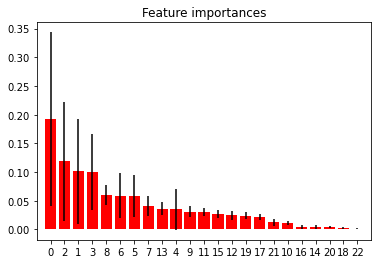

Feature ranking:
1 0.19225981350324245 contains_link
2 0.11878116525510522 stopwords
3 0.10130421998289069 word_count
4 0.1001427121131505 capital_count
5 0.05974140262441887 ref_count
6 0.058941154413736395 char_count
7 0.058619881157613345 flesch_grade
8 0.040888680956507904 longest_word
9 0.036253845541275816 average_word_length
10 0.03520567484207413 mentions
11 0.03109800716778199 amount_of_numbers
12 0.03096868953342343 compound
13 0.026670632808368854 neg
14 0.024455789068712055 neu
15 0.024099269459387025 extreme_Vader
16 0.021318507757038647 sentiment_textblob
17 0.01229759006972969 extreme_textblob
18 0.010642506877795282 sentiment_AFINN_SentStrength
19 0.004228711417369842 extreme_AFINN_SentStrength
20 0.004052491632684678 sentiment_ANEW
21 0.003511088882061529 extreme_ANEW
22 0.0029559761679842124 extreme_combined
23 0.0015621887676474727 CONJ


In [24]:
X_columns = X.columns.values.tolist()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print((f + 1), importances[indices[f]], X_columns[f])

We can see that the features that correlated the most also have the highest impact on the prediction. After 4 features it already goes down drastically and having the last few features in only makes a small impact on the performance of our model. 

#### Feature importance for the Retweets dataset

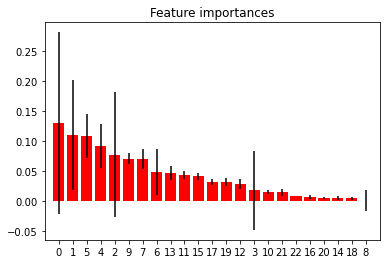

Feature ranking:
1 0.12947539031209626 char_count
2 0.11028367427812505 word_count
3 0.10880918252015986 longest_word
4 0.09129767702351953 ref_count
5 0.07689867862933242 stopwords
6 0.06980898288146553 average_word_length
7 0.06967308903136103 mentions
8 0.048138175160109466 flesch_grade
9 0.04620469271979172 contains_link
10 0.04307503291702186 capital_count
11 0.04058455064240408 amount_of_numbers
12 0.031891460884836735 compound
13 0.031204322616974967 neg
14 0.027906103928790612 neu
15 0.017674198671343455 extreme_Vader
16 0.01426833705321589 sentiment_textblob
17 0.01392295487375837 extreme_textblob
18 0.008021706588879603 sentiment_AFINN_SentStrength
19 0.0065247923822384455 extreme_AFINN_SentStrength
20 0.005013572711866452 sentiment_ANEW
21 0.004962206936959461 extreme_ANEW
22 0.0039064284048094975 extreme_combined
23 0.000454788830939718 CONJ


In [25]:
X_columns_noRT = X_noRT.columns.values.tolist()
importances = rf_noRT.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_noRT.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_noRT.shape[1]), indices)
plt.xlim([-1, X_noRT.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")
for f in range(X_noRT.shape[1]):
    print((f + 1), importances[indices[f]], X_columns_noRT[f])

In this list we can see that there are some differences between this model and the regular. The top10 features differ a bit, which we also already saw in the correlation matrix earlier. The last part is the same in order, but the values are lower. Meaning also less important. 


With the regular set we could see that the most important feature stands tall above the others, the no Retweet set is more gradual.

### Conclusion

We started with the question: "How well can we predict if a Tweet contains misinformation using machine learning?"

The Random Forest model performs very well in detecting Fake news. If we look at the no Retweet set the model is performing 42% better (60% to 85% right) than a random guess, the regular set is even perfoming 44% better (68% to 98% right). 

Features regarding the length and complexity of words have quite a big impact so that assumption was proven, sentiment features perform much lower than earlier expected and number features (except for amount_of_numbers) are not even selected as they had really low correlation with misinformation. These assumptions are therefor not proven.

In both sets it seems that simple text features work the best in detecting misinformation and we can predict misinformation quite accurately based on these features.


## Literature list

Al-Shabi, M. A. (2020). Evaluating the performance of the most important Lexicons used to Sentiment analysis and opinions Mining. IJCSNS International Journal of Computer Science and Network Security, 2020(1), https://www.researchgate.net/publication/343473213_Evaluating_the_performance_of_the_most_important_Lexicons_used_to_Sentiment_analysis_and_opinions_Mining

Bhutani, B., Rastogi, N., Sehgal, P., & Purwar, A. (2019, August). Fake News Detection Using Sentiment Analysis. IEEE.

ICMCIS 2020 Challenge. (2020). Kaggle. https://www.kaggle.com/c/icmcis2020/data

Kho, J. (2019, March 12). Why Random Forest is My Favorite Machine Learning Model. Medium. https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706

Li, Q., Hu, Q., Lu, Y., Yang, Y., & Cheng, J. (2019). Multi-level word features based on CNN for fake news detection in cultural communication. Personal and Ubiquitous Computing, 24(2), 259–272. https://doi.org/10.1007/s00779-019-01289-y

Probst, P., & Boulesteix, A. (2017, May). To tune or not to tune the number of trees in random forest? https://arxiv.org/pdf/1705.05654.pdf

San Martín, J., Drubi, F., & Rodríguez Pérez, D. (2020). Uncritical polarized groups: The impact of spreading fake news as fact in social networks. Mathematics and Computers in Simulation, 178, 192–206. https://doi.org/10.1016/j.matcom.2020.06.013

Su, Q., Wan, M., Liu, X., & Huang, C.-R. (2020). Motivations, Methods and Metrics of Misinformation Detection: An NLP Perspective. Natural Language Processing Research, 1–13. https://doi.org/10.2991/nlpr.d.200522.001